In [2]:
#Library 설치
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
# RetinaNet 모델 구현하기
from torchvision import models
# DataLoader 구축하기
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
#절대경로 변경
#os.chdir('C:/Users/user/Desktop/disease1') #dataset이 있는 경로로 변겅

In [3]:
print(torch.__version__)

1.13.1+cu116


In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Fri_Dec_17_18:28:54_Pacific_Standard_Time_2021
Cuda compilation tools, release 11.6, V11.6.55
Build cuda_11.6.r11.6/compiler.30794723_0


# 데이터 셋 확인

In [2]:
#경로설정
train_path='./train'
val_path='./valid'
test_path='./test'
# Train, Valid, Test 개수
print(len(os.listdir(train_path+'/'+'images')))
print(len(os.listdir(val_path+'/'+'images')))
print(len(os.listdir(test_path+'/'+'images')))

57
16
11


In [3]:
#train label파일 하나 보기
label_sample=os.listdir(train_path+'/'+'labels')[0]
# 라벨링 데이터 구조 확인
# 라벨링 파일 읽기
label=open(train_path+'/'+'labels'+'/'+label_sample,'r')
label=label.readlines()
print(label)

['0 0.66015625 0.52578125 0.0375 0.0484375']


In [9]:
# 해당 데이터는 질병 클래스 하나만 존재함
classes=['disease']
# 파일 리스트화
train_img_list=glob.glob(train_path+'/'+'images'+'/*') #이미지 파일명 리스트화
train_lab_list=glob.glob(train_path+'/'+'labels'+'/*') #라벨링 파일명 리스트화
print(len(train_img_list))
print(len(train_lab_list))
print(train_img_list[0])
print(train_lab_list[0])

57
57
./train/images\-11-_jpg.rf.782e8cbc39596b1b232d2af840b200f4.jpg
./train/labels\-11-_jpg.rf.782e8cbc39596b1b232d2af840b200f4.txt


In [10]:
# 파일명 확인
for i in range(len(train_img_list)):
    train_img_list[i]=train_img_list[i].replace('\\','/')
    train_lab_list[i]=train_lab_list[i].replace('\\','/')
    
#파일명 구조 변경
print(train_img_list[1])
print(train_lab_list[1])
img=cv2.imread(train_img_list[0])
print(img.shape)

./train/images/-15-_jpg.rf.be7c0174b33f297e30a8d7cde54481a0.jpg
./train/labels/-15-_jpg.rf.be7c0174b33f297e30a8d7cde54481a0.txt
(640, 640, 3)


In [11]:
#모든 이미지 width, height print 해보기

for i in range(len(train_img_list)):
    img=cv2.imread(train_img_list[i])
    print(img.shape)
    

(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)


# Bounding Box 좌표값 확인

기존의 좌표값에서 이미지 크기와 높이를 곱해서 xmin, ymin, xmax, ymax값 구함

# 라벨링 파일 바운딩박스 

RatinaNet을 Pytorch로 구현할 때 좌표값은 [xmin,ymin,xmax,ymax] 형태로 이루어져야 함

In [12]:
#5개의 값중 x,y,width,height만 이용하여 xmin,ymin,xmax,ymax

def bounding_box(file):
    img_width, img_height=640, 640
    boxes=[]
    column_name=['class','x','y','width','height']
    label_data=pd.read_csv(file,sep=' ',header=None,names=column_name)
    for i in range(len(label_data)):
        x,y,width,height=label_data.loc[i][1:5] #x,y,width,height 각 이미지별 좌표값 로드
        xmin,ymin,xmax,ymax=img_width*(x-width/2), img_height*(y-height/2), img_width*(x+width/2), img_height*(y+height/2) #xmin, ymin, xmax,ymax값으로 좌표값 변환
        bbox=[xmin,ymin,xmax,ymax] #4개의 좌표값 리스트화
        boxes.append(bbox) #빈 boxes 리스트에 좌표값 각각 추가
        
    return boxes

In [13]:
sample_b=bounding_box(train_lab_list[0])
print(sample_b)
print(type(sample_b))
print(len(sample_b))

[[410.5, 321.0, 434.5, 351.99999999999994]]
<class 'list'>
1


In [14]:
# # 5개 값중 class에 해당하는 값만 뽑아 label값으로 넣어줌

def label_value(file):
    labels=[]
    column_name=['class','x','y','width','height']
    label_data=pd.read_csv(file,sep=' ',header=None,names=column_name)
    for i in range(len(label_data)):
        label=label_data.loc[i][0]
        labels.append(label)
    #labels=torch.tensor(labels,dtype=torch.int64,device='cuda:0')
    return labels

In [15]:
sample_l=label_value(train_lab_list[0])
print(sample_l)
print(type(sample_l))

[0.0]
<class 'list'>


In [16]:
def generate_target(file):
    box=[]
    label=[]
    box=bounding_box(file) #ex)tensor([0.7750, 0.5023, 0.8094, 0.5258]
    label=label_value(file)  #파일명 하나씩 들어감 ex)[0, 0]
    target={}
    target["boxes"]=torch.tensor(box,dtype=torch.float32)
    target["labels"]=torch.tensor(label,dtype=torch.int64)
    
    return target

In [17]:
target_sample=generate_target(train_lab_list[0])
print(target_sample)
print(type(target_sample))
print(len(target_sample))
print(target_sample.keys())

{'boxes': tensor([[410.5000, 321.0000, 434.5000, 352.0000]]), 'labels': tensor([0])}
<class 'dict'>
2
dict_keys(['boxes', 'labels'])


# bounding with Image code

In [18]:
def bound_image(img_path,target):
    img=mpimg.imread(img_path)
    fig,ax=plt.subplots(1)
    ax.imshow(img)
    #print(img)
    
    for idx in range(len(target['boxes'])): #0,1,,,,,,, 객체갯수에따라
        xmin, ymin, xmax, ymax=target['boxes'][idx]
            
        if target['labels'][idx]==0: #병에 걸렸을때 빨간색 바운딩박스
            rect=patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        elif target['labels'][idx]==1: #병에 안걸렸을때 초록색 바운딩박스
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
        else:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')
        ax.add_patch(rect)
    
    plt.show()   

{'boxes': tensor([[275.0000, 332.7500, 304.0000, 380.2500],
        [284.2500, 439.2500, 313.7500, 484.7500],
        [319.0000, 547.2500, 345.0000, 598.7500]]), 'labels': tensor([0, 0, 0])}


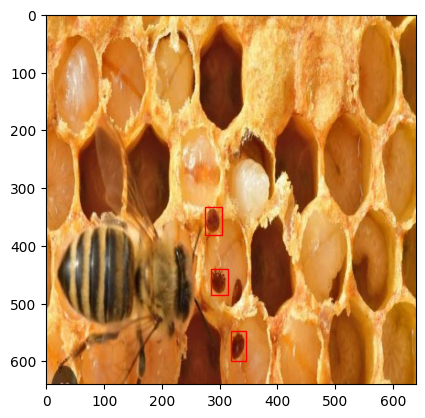

In [23]:
bbox1=generate_target(train_lab_list[7])
print(bbox1)
bound_image(train_img_list[7],bbox1)

# 이미지&바운딩박스 시각화

이미지, 좌표값, 라벨값 모두 시각화

여기서 좌표값과 라벨값은 모두 tensor로 변환된 상태임

# Custom Dataset

torchvision transform 사용하여 custom Dataset 만듬

In [24]:
# torchvision transform 사용
class disease_dataset(): #데이터 셋 경로, 데이터 전처리해주는 변환함수 등등을 적어주는 곳
    def __init__(self,path,transform=None):
        self.path=path #데이터셋 경로
        self.imgs=list(os.listdir(self.path)) #데이터셋 경로의 파일들
        self.transform=transform #데이터셋 변환해주는 함수
        
    def __len__(self): #데이터 셋의 길이를 적어저는 파트
        return len(self.imgs) #총 데이터 개수 리턴
    
    def __getitem__(self,idx): #데이터 슬라이싱 즉 총 데이터에서 1개씩 가져오는 함수임
        file_image=self.imgs[idx] #이미지 파일명 인덱스별로 추출
        file_label=self.imgs[idx][:-3]+'txt' #라벨링 파일명 인덱스별로 추출
        img_path=os.path.join(self.path,file_image) #이미지 경로
        img_path=img_path.replace('\\','/') #이미지 파일 경로 최종
        
        #라벨링 파일 경로 최종
        if 'test' in self.path:
            label_path=os.path.join('./test/labels/',file_label)
        elif 'train' in self.path:
            label_path=os.path.join('./train/labels/',file_label)
        elif 'valid' in self.path:
            label_path=os.path.join('./valid/labels/',file_label)
            
        img=Image.open(img_path).convert('RGB') #이미지 데이터 하나씩 Open
        target=generate_target(label_path) #라벨링파일 1개씩 오픈
        start=time.time() #시작시간
        if self.transform: #이미지 텐서변환해줌
            img=self.transform(img)
        total_time=(time.time()-start)
        
        return img, target #최종적으로 이미지 텐서 변환값고, 타겟값 딕셔너리 추출

In [25]:
#Data augmentation은 진행하지 않고, Resize와 이미지 Tensor변환만 진행함
data_transform=transforms.Compose([
    transforms.Resize((640,640)),
    transforms.ToTensor(),
])

In [26]:
train_dataset=disease_dataset(path=train_path+'/'+'images',transform=data_transform)
val_dataset=disease_dataset(path=val_path+'/'+'images',transform=data_transform)
test_dataset=disease_dataset(path=test_path+'/'+'images',transform=data_transform)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

57
16
11


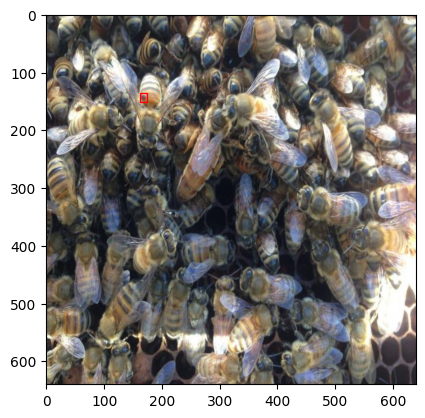

In [29]:
# custom dataset은 이미지, (좌표값,라벨값)
img, target=train_dataset[10]
# 변환된 이미지 확인
def plot_image_transform(img,target):
    img=img.permute(1,2,0)
    fig,ax=plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(target['boxes'])): #0,1,,,,,,, 객체갯수에따라
        xmin, ymin, xmax, ymax=target['boxes'][idx]
            
        if target['labels'][idx]==0: #병에 걸렸을때 빨간색 바운딩박스
            rect=patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        elif target['labels'][idx]==1: #병에 안걸렸을때 초록색 바운딩박스
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
        else:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')
        ax.add_patch(rect)
    
    plt.show()   

plot_image_transform(img,target) 

# DataLoader 정의

In [21]:
#collate_fn 함수를 사용하여 각 샘플을 미리 처리하고 일관된 형식으로 반환하도록 지정
def collate_fn(batch):
    return tuple(zip(*batch))

In [22]:
#batch 단위로 dataloader를 구성함
train_loader=DataLoader(train_dataset,batch_size=4,collate_fn=collate_fn)
print(len(train_loader))
test_loader=DataLoader(test_dataset,batch_size=2,collate_fn=collate_fn)
print(len(test_loader))
val_loader=DataLoader(val_dataset,batch_size=2,collate_fn=collate_fn)
print(len(val_loader))

9
4
5


# train data, test data 전체 객체개수 확인

In [23]:
def get_object(label_path):
    total=0
    column_name=['class','x','y','width','height']
    for i in os.listdir(label_path): #train)_paht+'/'+label->파일명
        label_data=pd.read_csv(label_path+'/'+i,sep=' ',header=None,names=column_name)
        total += len(label_data)
    return total 

train_object=get_object(train_path+'/'+'labels')
print(train_object)
val_object=get_object(val_path+'/'+'labels')
print(val_object)
test_object=get_object(test_path+'/'+'labels')
print(test_object)

157
25
18


# Retina Model 구현하기 Dataloader 정의하기

In [24]:
#응애는 pretrained된게 없기 때문에 False로 지정하고 num_class=1로 지정함
#전이학습으로 진행
from torchvision import models
Retina_Model=models.detection.retinanet_resnet50_fpn(num_classes=1,pretrained=False,pretrained_backbone=True)

In [25]:
epochs=200
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
Retina_Model.to(device) #GPU사용
params=[p for p in Retina_Model.parameters() if p.requires_grad] #기울기 계산이 필요한 params만 추출하기
optimizer=torch.optim.Adam(params,lr=0.001, weight_decay=1e-3) #논문에서와 같이 Adam optimizer사용
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20, verbose=True) # ReduceLROnPlateau 초기화

cuda


In [30]:
# Parameter 설정

for epoch in range(epochs): 
    print(f'{epoch+1}번째 epoch시작') #한 epoch 시작할때마다 print
    start = time.time()
    Retina_Model.train()  #Model 전이학습이기 때문에 train모드로 변경
    train_loss = 0 #epoch loss 계산을 위해 0으로 설정, 한 에포크가 끝나면 초기화됨
    for images, targets in train_loader: #train loader에서 이미지와 targets 추출, 설정해준 배치사이즈만큼 추출됨
        images = list(image.to(device) for image in images) #리스트당 4개 이미지 Tensor data GPU메모리로 이동
        targets=[{k:v.to(device) for k,v in i.items()}for i in targets] #box좌표와 ,라벨좌표 GPU메모리로 이동
        optimizer.zero_grad()
        loss_dict=Retina_Model(images,targets) #classfication loss, bbox_regression
        #print(loss_dict)
        losses = sum(loss for loss in loss_dict.values()) 
        losses.backward()
        optimizer.step()
        train_loss += losses 
    train_loss /= len(train_loader) #epoch당 평균 손실값 구하기
    print(train_loss, f'time: {time.time() - start}')

1번째 epoch시작
tensor(1.6638, device='cuda:0', grad_fn=<DivBackward0>) time: 4.112071990966797
2번째 epoch시작
tensor(1.6781, device='cuda:0', grad_fn=<DivBackward0>) time: 3.7240090370178223
3번째 epoch시작
tensor(1.8272, device='cuda:0', grad_fn=<DivBackward0>) time: 3.732999801635742
4번째 epoch시작
tensor(1.7854, device='cuda:0', grad_fn=<DivBackward0>) time: 3.733057737350464
5번째 epoch시작
tensor(1.7274, device='cuda:0', grad_fn=<DivBackward0>) time: 3.735999345779419
6번째 epoch시작
tensor(1.8398, device='cuda:0', grad_fn=<DivBackward0>) time: 3.7410037517547607
7번째 epoch시작
tensor(1.7868, device='cuda:0', grad_fn=<DivBackward0>) time: 3.7421298027038574
8번째 epoch시작
tensor(1.7237, device='cuda:0', grad_fn=<DivBackward0>) time: 3.7480006217956543
9번째 epoch시작
tensor(1.6242, device='cuda:0', grad_fn=<DivBackward0>) time: 3.745067834854126
10번째 epoch시작
tensor(1.6580, device='cuda:0', grad_fn=<DivBackward0>) time: 3.74812912940979
11번째 epoch시작
tensor(1.5983, device='cuda:0', grad_fn=<DivBackward0>) time: 3

In [32]:
torch.save(Retina_Model.state_dict(),f'retina_{epochs}.pt')
Retina_Model.load_state_dict(torch.load(f'retina_{epochs}.pt'))

<All keys matched successfully>

In [33]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
Retina_Model.to(device)

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, e

In [47]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : #threshold 넘는 idx 구함
                idx_list.append(idx)
                print(len(idx_list))

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]


    return preds

In [48]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(Retina_Model, im, 0.01)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.81it/s]


In [45]:
def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    rects = []

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        rects.append(rect)

    return img, rects

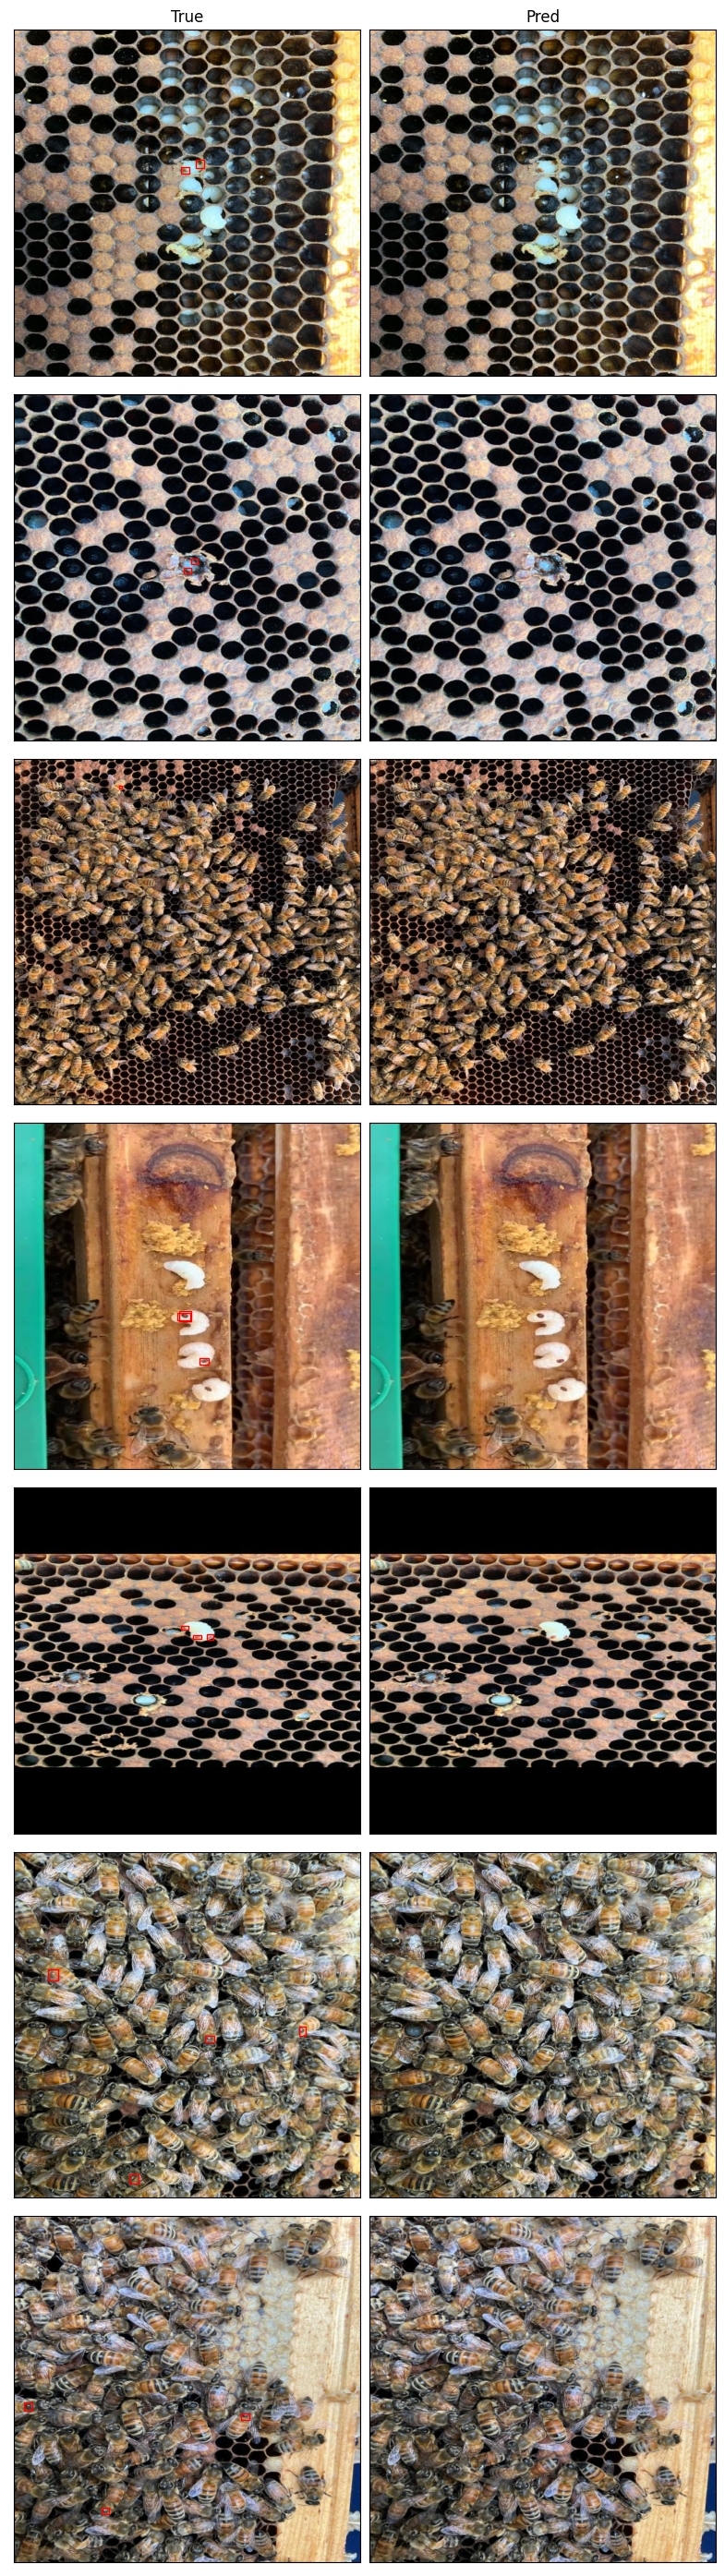

In [46]:
nrows = 7
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))

batch_i = 0
for im, annot in test_loader:
    pos = batch_i * 4 + 1
    for sample_i in range(len(im)) :
        
        img, rects = plot_image_from_output(im[sample_i], annot[sample_i])
        axes[(pos)//2, 1-((pos)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos)%2)].add_patch(rect)
        
        img, rects = plot_image_from_output(im[sample_i], preds_adj_all[batch_i][sample_i])
        axes[(pos)//2, 1-((pos+1)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos+1)%2)].add_patch(rect)

        pos += 2

    batch_i += 1
    if batch_i == 4:
        break

# xtick, ytick 제거
for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

colnames = ['True', 'Pred']

for idx, ax in enumerate(axes[0]):
    ax.set_title(colnames[idx])

plt.tight_layout()
plt.show()